# Homework 7

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence except for 2 of the entries, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [2]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalized scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

## Question 1

In [3]:
!pip install torchinfo

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchinfo import summary

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#We are using the addition_problem function that is given to generate tensor training batches

def addition_problem_batch(batch_size = 32, sequence_length=50):
    pairs = [addition_problem() for _ in range(batch_size)]
    inputs, outputs = np.array([pair[0] for pair in pairs]), np.array([pair[1] for pair in pairs])
    input_tensor = torch.from_numpy(inputs).float()
    output_tensor = torch.from_numpy(outputs).float()
    return input_tensor, output_tensor

In [8]:
class AttentionPooler(nn.Module):
    def __init__(self, input_dim, hid_dim, attn_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, input_dim)

        self.q = nn.Parameter(torch.randn(attn_dim, 1))
        self.W_a = nn.Parameter(torch.randn(input_dim, attn_dim))
        self.b_a = nn.Parameter(torch.randn(attn_dim))

        self.fc2 = nn.Linear(input_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, 1)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        #Feed-forward between the input sequence for the attention and the input x
        h = torch.tanh(self.fc1(x))

        #Attention energies computation
        e_t = torch.tanh(torch.matmul(h, self.W_a) + self.b_a)
        e_t = torch.matmul(e_t,self.q).squeeze(-1)

        #Average attention pooling for the context vector c (softmax is computed on axis = 1)
        alpha = self.softmax(e_t).unsqueeze(-1)

        c = torch.sum(alpha * h, dim=1)

        #Two feed-forward layers before output
        out = self.fc2(c)
        out = torch.tanh(out)
        out = self.fc3(out)

        return out

In [9]:
batch_size = 512

model = AttentionPooler(input_dim = 2, hid_dim = 64, attn_dim = 128).to(device)
summary(model, input_size=(batch_size, 50, 2), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
AttentionPooler                          [512, 1]                  512
├─Linear: 1-1                            [512, 50, 2]              6
├─Softmax: 1-2                           [512, 50]                 --
├─Linear: 1-3                            [512, 64]                 192
├─Linear: 1-4                            [512, 1]                  65
Total params: 775
Trainable params: 775
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.20
Forward/backward pass size (MB): 0.68
Params size (MB): 0.00
Estimated Total Size (MB): 0.88

In [10]:
num_epochs = 10000
lr = 0.01
momentum = 0.9
weight_decay = 0.0005
grad_clip = 0.1

In [11]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)

In [12]:
loss_list = []

torch.cuda.empty_cache()

#The same loop we've been using since a few homeworks now
for epoch in range(num_epochs):

    inputs, labels = addition_problem_batch(batch_size)
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(labels, outputs)

    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()

    if not (epoch+1) % 500:
      print(f'Epoch {epoch+1}, Loss: {loss.item()}')

print('Finished Training')

Epoch 500, Loss: 0.0015728658763691783
Epoch 1000, Loss: 0.0006013690144754946
Epoch 1500, Loss: 0.0004105425614397973
Epoch 2000, Loss: 0.0003435192338656634
Epoch 2500, Loss: 0.00036479058326222
Epoch 3000, Loss: 0.0002458946546539664
Epoch 3500, Loss: 0.0002940136182587594
Epoch 4000, Loss: 0.00026020355289801955
Epoch 4500, Loss: 0.00033414969220757484
Epoch 5000, Loss: 0.00028573686722666025
Epoch 5500, Loss: 0.00033164446358568966
Epoch 6000, Loss: 0.0003596525057218969
Epoch 6500, Loss: 0.0003183507069479674
Epoch 7000, Loss: 0.0003565773949958384
Epoch 7500, Loss: 0.0003355924563948065
Epoch 8000, Loss: 0.00032103166449815035
Epoch 8500, Loss: 0.000320181658025831
Epoch 9000, Loss: 0.0003633923188317567
Epoch 9500, Loss: 0.0003030033258255571
Epoch 10000, Loss: 0.0002649394446052611
Finished Training


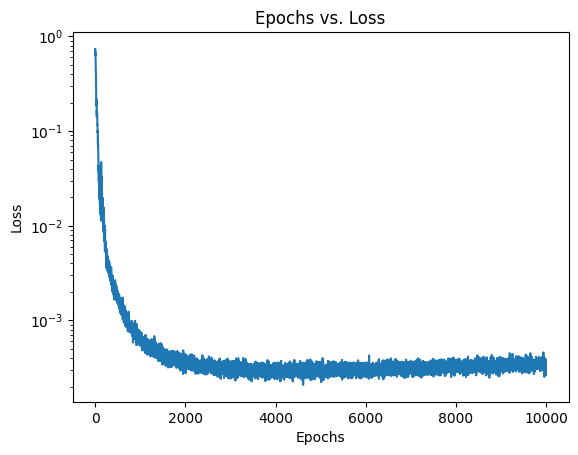

In [19]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')
plt.yscale('log')
plt.plot(loss_list);

The final loss at the end of the training is under 0.05.

## Question 2

In [67]:
model.eval()

AttentionPooler(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)

In [20]:
#Let's compute the average MSE on a batch of 1000 sequences for different sequence lenghts between 50 and 150

seq_lenght_list = [i for i in range(50,150)]
loss_list = []
with torch.no_grad():
    for sequence_length in seq_lenght_list:
      input, label = addition_problem_batch(1000, sequence_length)
      input, label = input.to(device), label.to(device)
      output = model(input)
      loss_list.append(criterion(output,label).item())

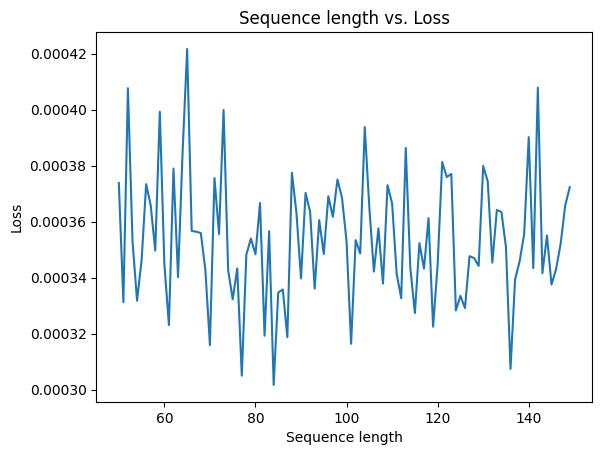

In [21]:
plt.xlabel('Sequence length')
plt.ylabel('Loss')
plt.title('Sequence length vs. Loss')
plt.plot(seq_lenght_list,loss_list);

The model learnt to solve the addition problem and is able to generalize whatever the sequence length is. The MSE loss is under 0.05 for all the tested sequence length values.